# HPO Synergy Analysis Workflow

This notebook demonstrates a complete workflow for analyzing phenopacket data using the `ppkt2synergy` package. It includes steps for loading data, generating HPO term matrices and binary disease targets, and performing synergy analyses, including visualization of the results.

---

## Install Dependencies

To get started, ensure you have the required libraries installed. Run the following command in your terminal or command prompt to install `ppkt2synergy` and `gpsea`:

```bash
pip install ppkt2synergy gpsea

## Import Libraries
Once the dependencies are installed, import the necessary libraries to begin your analysis:

In [1]:
from ppkt2synergy import CohortDataLoader, PhenopacketMatrixProcessor,PairwiseSynergyAnalyzer
from gpsea.model import VariantEffect

### **Synergy Analysis Between HPO Terms and Targets in a Single Cohort**

This section demonstrates how to perform synergy analysis between HPO terms and target variables (e.g., disease status, sex, or variant effects) within a single cohort. The analysis helps identify synergistic relationships where combinations of phenotypic features are more informative of the target than individual terms alone.

---

##### **Loading Data and Preparing HPO Matrices**

In [2]:
cohort_name = "FBN1"
mane_tx_id = 'NM_000138.5'
varsiant_effect_type = VariantEffect.MISSENSE_VARIANT
phenopackets = CohortDataLoader.from_ppkt_store(cohort_name=cohort_name)
hpo_matrix, target_matrix= PhenopacketMatrixProcessor.prepare_hpo_data(
    variant_effect_type=varsiant_effect_type,
    mane_tx_id=mane_tx_id, 
    phenopackets=phenopackets, 
    threshold=0, 
    mode=None, 
    use_label=True,
    nan_strategy=None)

Individuals Processed: 100%|██████████| 144/144 [00:01<00:00, 91.43 individuals/s] 


Select a target from following targets:

In [3]:
target_matrix.columns

Index(['Acromicric dysplasia', 'Ectopia lentis, familial', 'Marfan syndrome',
       'Stiff skin syndrome', 'Geleophysic dysplasia 2',
       'Marfan lipodystrophy syndrome', 'sex', 'missense_variant'],
      dtype='object')

##### **Pairwise Synergy Analysis and Ploting**
We compute pairwise synergy scores between HPO terms for predicting the target (Acromicric dysplasia) using permutation testing.

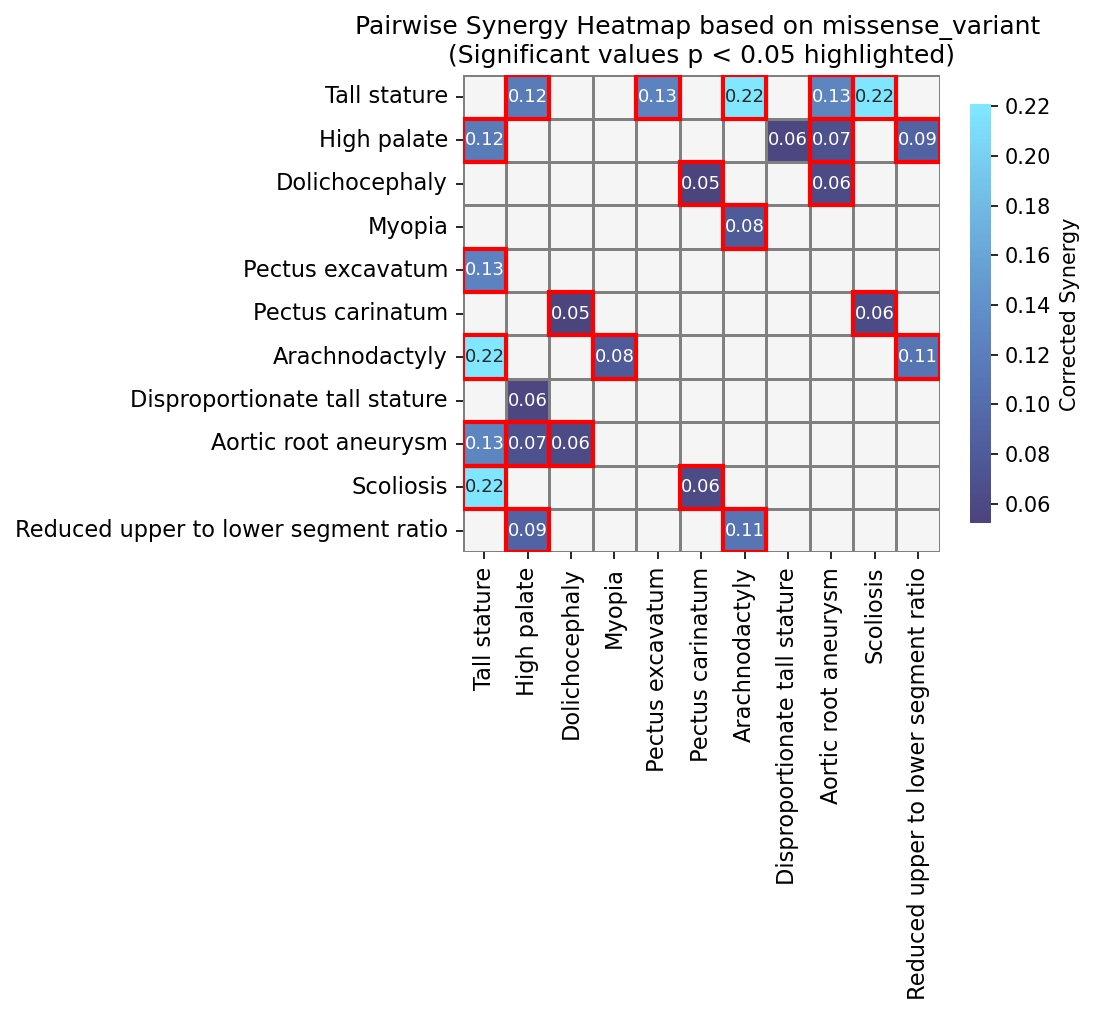

In [4]:
target=target_matrix['missense_variant']
synergy_analyzer=PairwiseSynergyAnalyzer(
    hpo_data=hpo_matrix, 
    target=target,
    n_permutations=1000,
    min_individuals_for_synergy_caculation=40,
    random_state=40)
synergy_matrix, pval_matrix = synergy_analyzer.compute_synergy_matrix(n_jobs=32)
synergy_analyzer.plot_synergy_heatmap(
    lower_bound=0.05,
    significance_threshold=0.05,
    target_name=target.name
    
)

### **Synergy Analysis for Terms Across Multiple Cohorts**
This section demonstrates how to perform pairwise synergy analysis between HPO terms given by various targets (e.g., disease status, sex, or variant effects) across multiple cohorts.

---

##### **Loading Data and Preparing HPO Matrices**

In [5]:
multi_cohort_names = ["TGFBR1","TGFBR2","SMAD3","TGFB2","TGFB3","SMAD2"]
multi_mane_tx_ids = ['NM_004612.4','NM_003242.6','NM_005902.4','NM_003238.6','NM_003239.5','NM_005901.6']
multi_varsiant_effect_type = VariantEffect.MISSENSE_VARIANT

# Load phenopackets from multiple cohorts
multi_phenopackets = CohortDataLoader.from_ppkt_store(cohort_name=multi_cohort_names)

# Prepare HPO and target matrices for multiple cohorts
multi_hpo_matrix, multi_target_matrix = PhenopacketMatrixProcessor.prepare_hpo_data(
    multi_phenopackets,
    variant_effect_type=multi_varsiant_effect_type,
    mane_tx_id=multi_mane_tx_ids,
    threshold=0,
    mode=None,
    use_label=True,
    nan_strategy=None
)

Individuals Processed: 100%|██████████| 277/277 [00:07<00:00, 37.97 individuals/s]


Select a target from following targets:

In [6]:
multi_target_matrix.columns

Index(['Multiple self-healing squamous epithelioma, susceptibility to',
       'Loeys-Dietz syndrome 1', 'Loeys-Dietz syndrome 2',
       'Loeys-Dietz syndrome 3', 'Loeys-Dietz syndrome 4',
       'Loeys-Dietz syndrome 5', 'Loeys-Dietz syndrome 6',
       'Congenital heart defects, multiple types, 8, with or without heterotaxy',
       'sex', 'missense_variant'],
      dtype='object')

##### **Pairwise Synergy Analysis and Ploting**

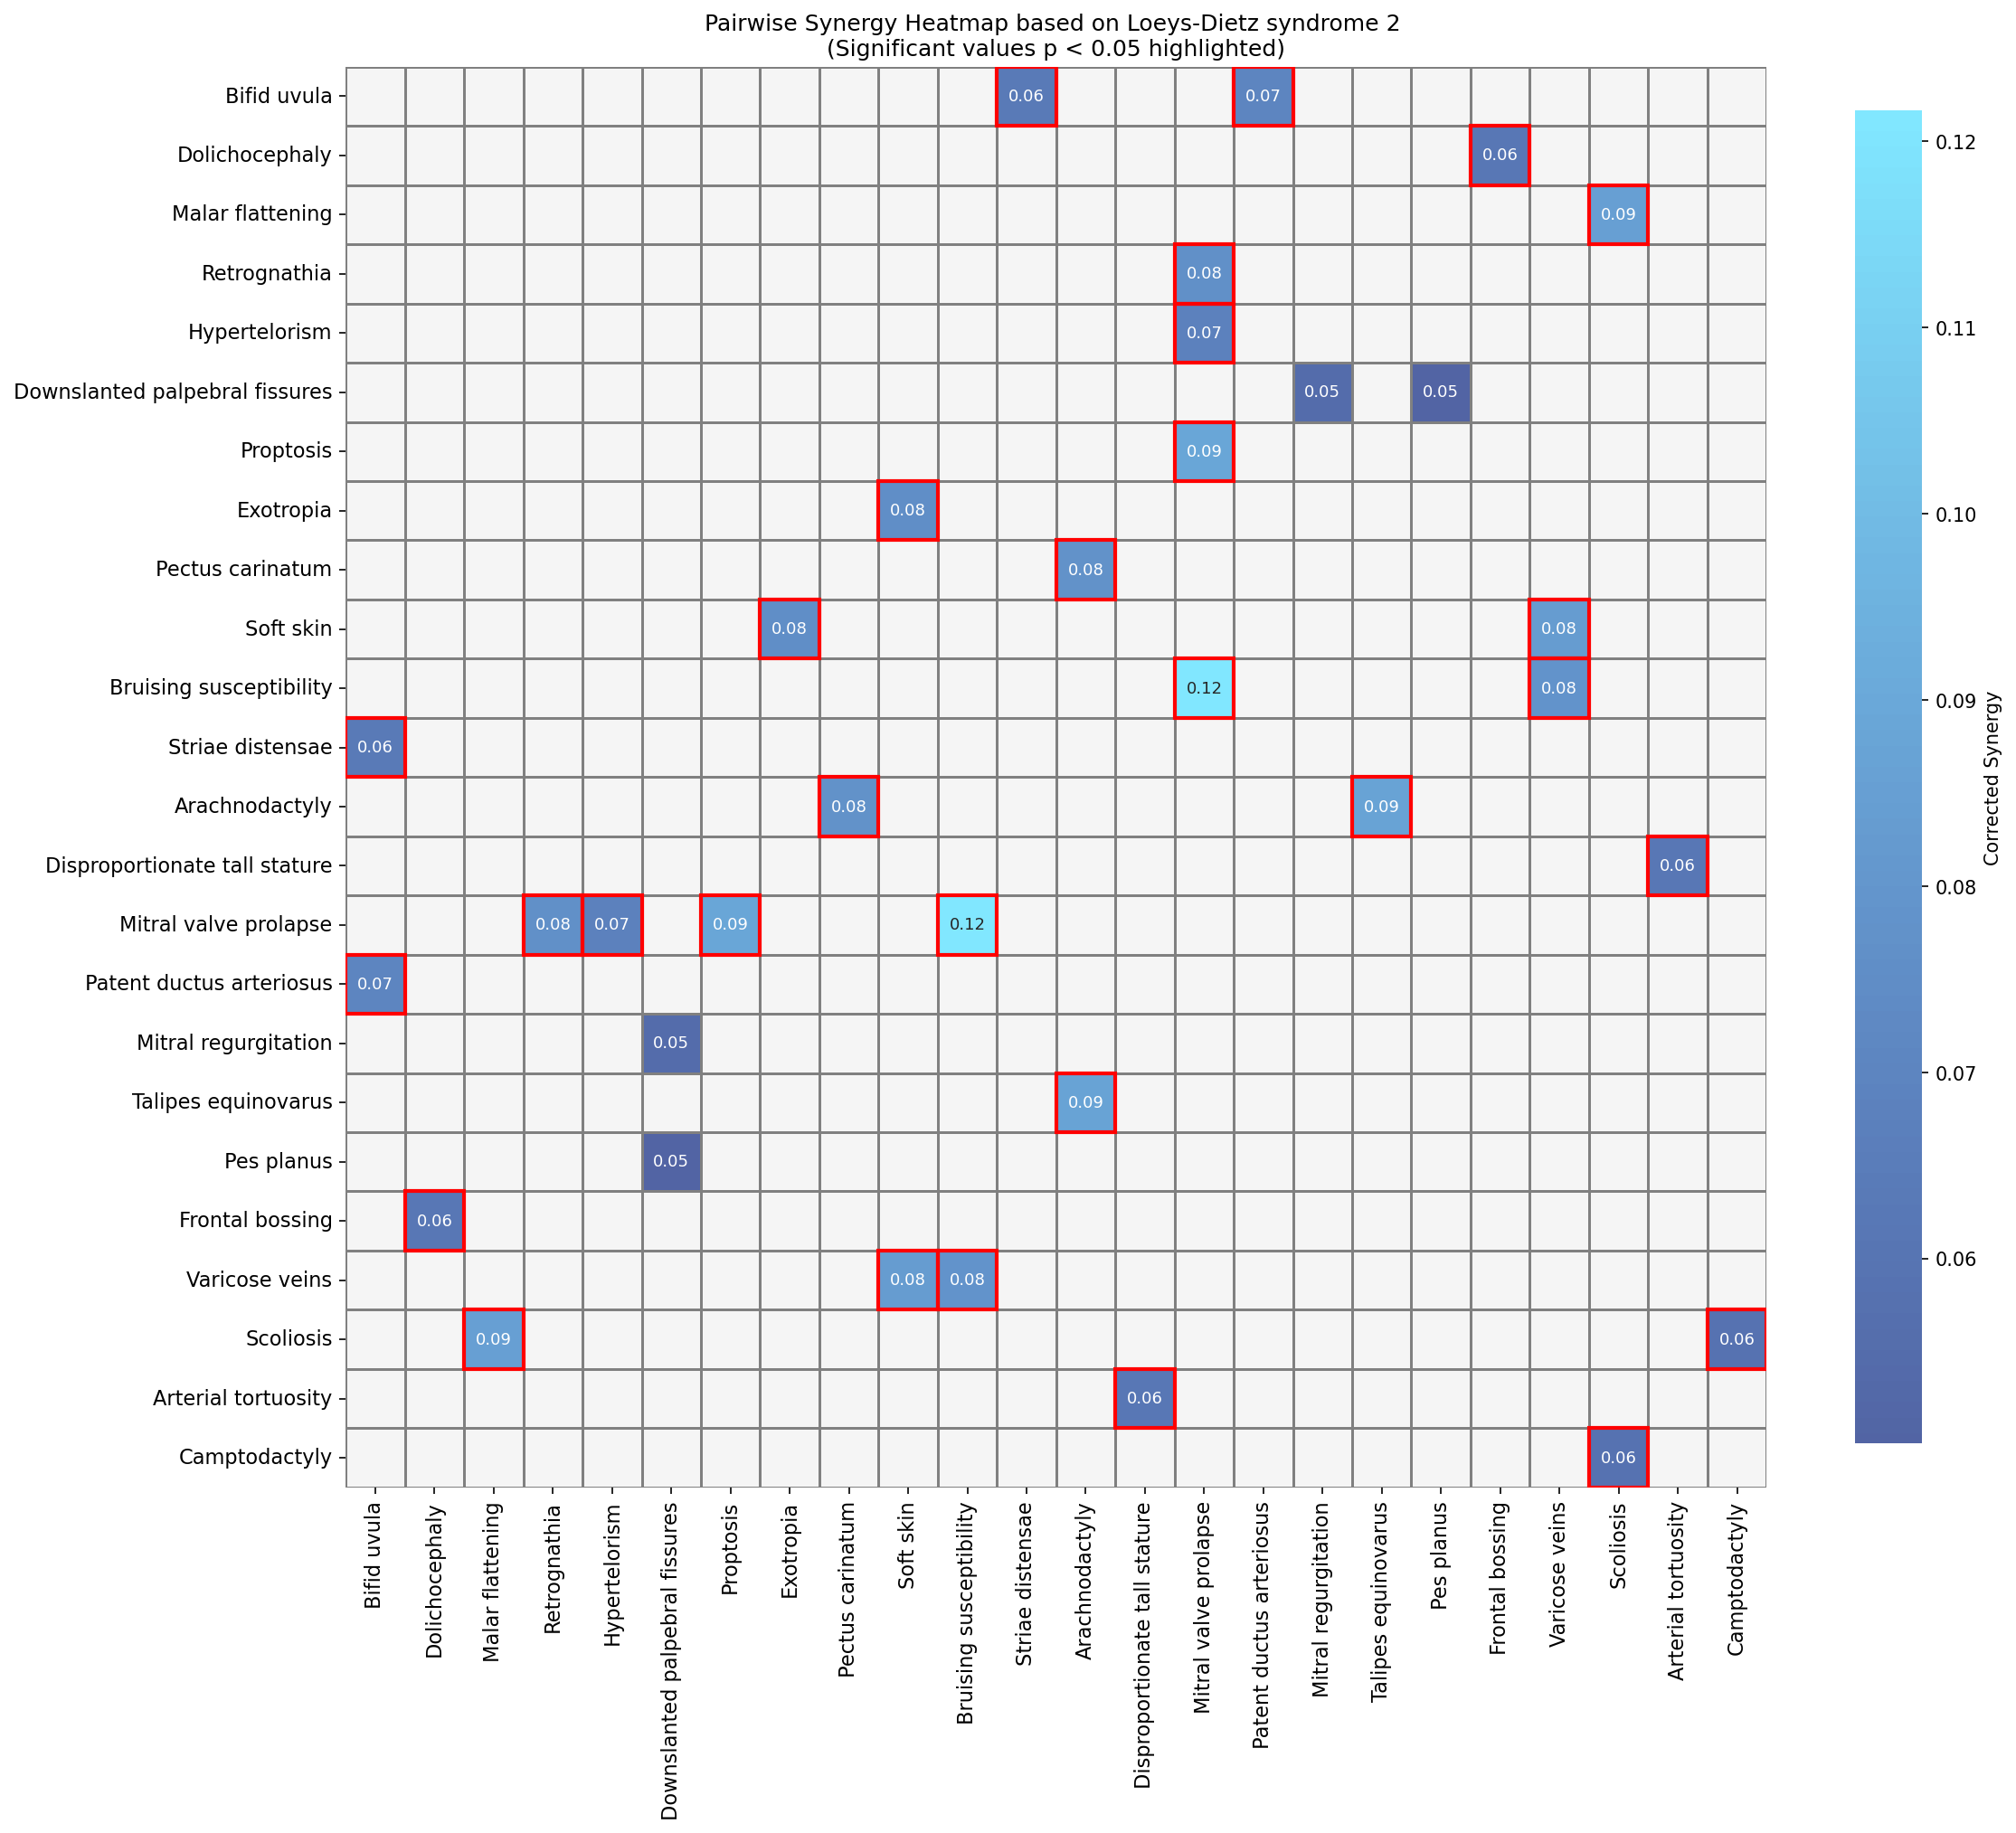

In [7]:
# Select disease target from multi-cohort target matrix
multi_target = multi_target_matrix['Loeys-Dietz syndrome 2']

# Initialize synergy analyzer for multiple cohorts
multi_synergy_analyzer = PairwiseSynergyAnalyzer(
    hpo_data=multi_hpo_matrix,
    target=multi_target,
    n_permutations=1000,
    min_individuals_for_synergy_caculation=40,
    random_state=40,
)

# Compute synergy values
multi_synergy_matrix, multi_pval_matrix = multi_synergy_analyzer.compute_synergy_matrix(n_jobs=32)

# Plot synergy heatmap
multi_synergy_analyzer.plot_synergy_heatmap(
    lower_bound=0.05,
    significance_threshold=0.05,
    target_name=multi_target.name
)

### **Comprehensive Synergy Analysis Across All Cohorts in Phenopacket Store**

This section demonstrates how to conduct synergy analysis between HPO terms and targets such as disease status, sex, or variant effects across all cohorts available in the Phenopacket Store.

We start by loading a zipped phenopacket dataset, selecting target cohorts (FBN1), and defining a binary target matrix to distinguish between selected and non-selected cohorts. We then prepare the HPO term matrix and the external target matrix. Finally, synergy scores are computed to identify pairs of HPO terms that jointly provide more predictive power for the target than expected from their individual associations.

This comprehensive approach provides insight into synergistic relationships between phenotypes and disease-related variables across multiple cohorts.

---

##### **Extracting Phenopackets and Creating a Target Matrix for Multiple Cohorts**
The following demonstrates how to extract phenopackets for multiple target cohorts and create a binary target matrix indicating the presence of these cohorts.

In [8]:
from pathlib import Path
import zipfile
from ppktstore.model import PhenopacketStore
import pandas as pd

target_cohort_names = ['FBN1'] 
current_dir = Path().resolve()
ppkt_zip_path = current_dir.parent.parent / "tests" / "data" / "all_phenopackets.zip"

with zipfile.ZipFile(ppkt_zip_path) as zf:
    store = PhenopacketStore.from_release_zip(zf)

target_ppkts = []
for name in target_cohort_names:
    target_ppkts.extend(store.cohort_for_name(name).iter_phenopackets())

non_target_cohorts = {name: cohort for name, cohort in store._cohorts.items() if name not in target_cohort_names}
non_target_ppkts = [ppkt for cohort in non_target_cohorts.values() for ppkt in cohort.iter_phenopackets()]

all_ppkts = target_ppkts + non_target_ppkts
external_target_matrix = pd.DataFrame(
    data=[1]*len(target_ppkts) + [0]*len(non_target_ppkts),
    index=[ppkt.id for ppkt in all_ppkts],
    columns=[f"is_{'_'.join(target_cohort_names)}"])

##### **Loading Data and Preparing HPO Matrices**

In [9]:
all_hpo_matrix, all_target_matrix = PhenopacketMatrixProcessor.prepare_hpo_data(
    phenopackets=all_ppkts, 
    external_target_matrix=external_target_matrix, 
    threshold=0, 
    mode=None, 
    use_label=True,
    nan_strategy= None
)

target_hpo_matrix, target_target_matrix = PhenopacketMatrixProcessor.prepare_hpo_data(
    phenopackets=target_ppkts,  
    threshold=0, 
    mode=None, 
    use_label=True,
    nan_strategy=None
)

common_columns = all_hpo_matrix[0].columns.intersection(target_hpo_matrix[0].columns)
all_hpo_matrix_filtered = all_hpo_matrix[0][common_columns]

Select a target from following targets:

In [10]:
all_target_matrix.columns

Index(['Apert syndrome', 'Acromicric dysplasia', 'Hajdu-Cheney syndrome',
       'Severe combined immunodeficiency due to ADA deficiency',
       'Tietz albinism-deafness syndrome', 'Pseudohypoparathyroidism Ia',
       'Amelogenesis imperfecta, type IA', 'Amyloidosis, Finnish type',
       'Amyotrophic lateral sclerosis 1', 'Diamond-Blackfan anemia 1',
       ...
       'Ovarian dysgenesis 11',
       'Immunodeficiency 123 with HPV-related verrucosis',
       'Polycystic kidney disease 8',
       'Spastic paraplegia 93, autosomal recessive',
       'Intellectual developmental disorder, autosomal dominant 75',
       'Spermatogenic failure 96', 'Premature ovarian failure 25',
       'Basal ganglia calcification, idiopathic, 10, autosomal recessive',
       'sex', 'is_FBN1'],
      dtype='object', length=518)

##### **Pairwise Synergy Analysis and Ploting**

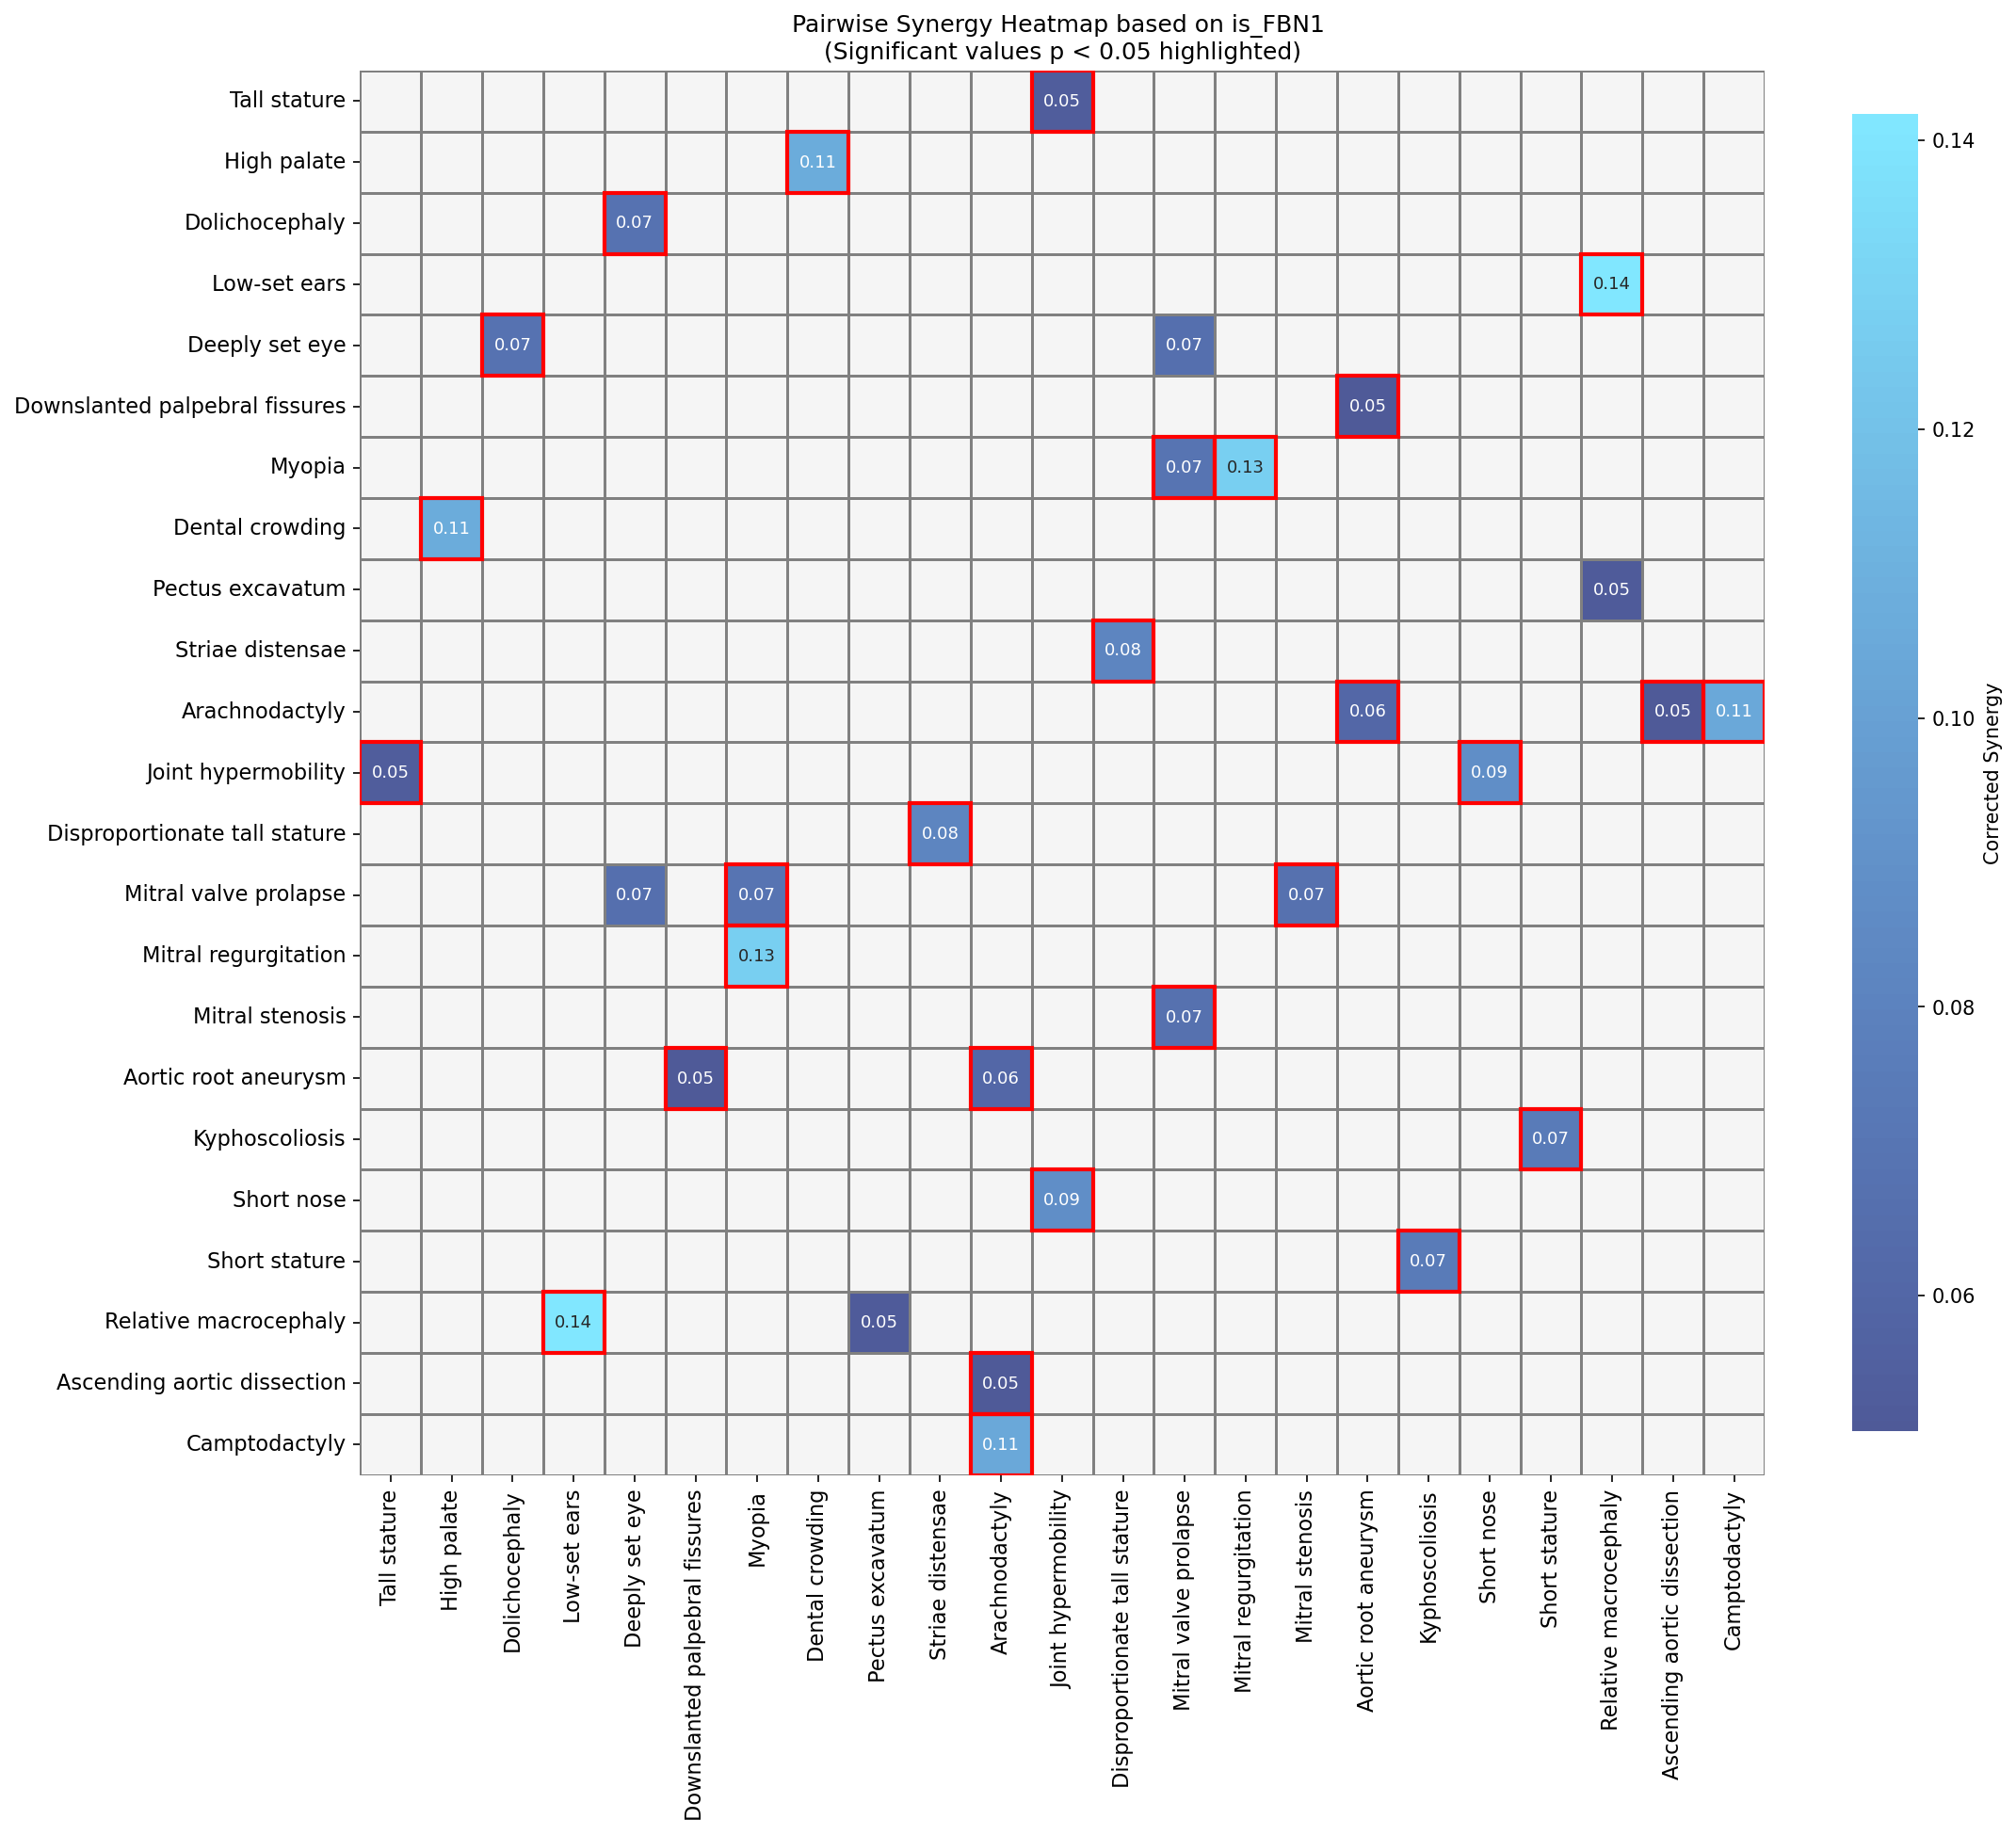

In [11]:
all_target=all_target_matrix['is_FBN1']
all_synergy_analyzer=PairwiseSynergyAnalyzer(
    hpo_data=(all_hpo_matrix_filtered,target_hpo_matrix[1]), 
    target=all_target,
    n_permutations=1000,
    min_individuals_for_synergy_caculation=40,
    random_state=40,)
all_synergy_matrix, all_pval_matrix = all_synergy_analyzer.compute_synergy_matrix(n_jobs=32)
all_synergy_analyzer.plot_synergy_heatmap(
    lower_bound=0.05,
    significance_threshold=0.05,
    target_name=all_target.name)